In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

#from flashtext import KeywordProcessor # extract keywords or replace keywords in sentences.faster than replace

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chrys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chrys\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


READ THE **DATASETS**

In [3]:
df_train = pd.read_csv('train.csv', encoding='latin1')
print('The shape of train is:', df_train.shape)
df_train.info()
len_train = df_train.shape[0]
print('The len_train is: ', len_train)

df_test = pd.read_csv('test.csv', encoding='latin1')
print('\n The shape of test is: ', df_test.shape)
df_test.info()

df_product_desc = pd.read_csv('product_descriptions.csv')
print('\n The shape of product description is: ', df_product_desc.shape)
df_product_desc.info()

df_product_attr = pd.read_csv('attributes.csv')
print('\n The shape of product attributes is: \n', df_product_attr.shape)
print('The null values of are: ', df_product_attr.isnull().sum())
df_product_attr.dropna(how="all", inplace=True)
df_product_attr["product_uid"] = df_product_attr["product_uid"].astype(int)
print(df_product_attr.info())

The shape of train is: (74067, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
product_title    74067 non-null object
search_term      74067 non-null object
relevance        74067 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB
The len_train is:  74067

 The shape of test is:  (166693, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 4 columns):
id               166693 non-null int64
product_uid      166693 non-null int64
product_title    166693 non-null object
search_term      166693 non-null object
dtypes: int64(2), object(2)
memory usage: 5.1+ MB

 The shape of product description is:  (124428, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124428 entries, 0 to 124427
Data columns (total 2 columns):
product_uid            124428 non-null int64
product_descrip

MERGE DATASETS

In [4]:
df_train_test = pd.concat((df_train, df_test), axis=0, ignore_index=True)
print('The shape of train-test is: ', df_train_test.shape)
df_train_test.info()

df_merged = df_train_test.merge(df_product_desc, how='left', right_on='product_uid', left_on='product_uid')
print('\n The shape of train_test with products_description is: ', df_merged.shape)
df_merged.info()

# THIS IS THE MERGE WITH attributes DATASET. I DIDN'T MERGED IT BECAUSE OF THE NULL VALUES. UNCOMMENT TO SEE.
df_all =  df_merged.merge(df_product_attr, how='left', right_on='product_uid', left_on='product_uid')
print('\n The shape of final df is: ', df_all.shape)
print(df_all.info())
print('\n The sums of null values of the each column of this dataframe are:', df_all.isnull().sum())

C:\Users\chrys\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


The shape of train-test is:  (240760, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240760 entries, 0 to 240759
Data columns (total 5 columns):
id               240760 non-null int64
product_title    240760 non-null object
product_uid      240760 non-null int64
relevance        74067 non-null float64
search_term      240760 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 9.2+ MB

 The shape of train_test with products_description is:  (240760, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240760 entries, 0 to 240759
Data columns (total 6 columns):
id                     240760 non-null int64
product_title          240760 non-null object
product_uid            240760 non-null int64
relevance              74067 non-null float64
search_term            240760 non-null object
product_description    240760 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 12.9+ MB

 The shape of final df is:  (4884406, 8)
<class 'pandas.core.frame.DataF


**TEXT PREPROCESSING FUNCTIONS**

> *punctuations - stopwords - stemming *




In [5]:
# Function to perform 2 different stemmings
def perform_stemming(text, porter=None, snowball=None):
    """
    This function preprocess a string:
      1. Add space after the "."
      2. Add space after the ";"
      3. Remove digits not contained in a word
      4. Perform stemming with 2 options (PorterStemmer & SnowballStemmer)
    Input: A string
    Output: A string with stem words
    Example: text = perform_stemming(text, snowball=True)
    """
    regex1 = r"\.(?!\s)(?!$)"
    sub1 = ". "
    text = re.sub(regex1, sub1, text) # add space after . if it doesn't exist.also avoid add space after the last .
    
    regex2 = r"\;(?!\s)(?!$)"
    sub2 = "; "
    text = re.sub(regex2, sub2, text)  # do this also for ;
    
    regex3 = r"(\w)([A-Z])"
    sub3 = r"\1 \2"
    text = re.sub(regex3, sub3, text) # add space Capital words that are in the form textTex
    
    regex4 = r"(\s\d+)"
    sub4 = ""
    text = re.sub(regex3, sub3, text) # remove digits that do not contained in a word OR you can use '\w*\d\w*' to remove also words that contain digits inside them
    
    if porter:
        porter_stemmer = PorterStemmer()
        stem_words = ' '.join([porter_stemmer.stem(word) for word in text.lower().split()])

    if snowball:
        snowball_stemmer = SnowballStemmer('english', ignore_stopwords=True)
        text = text.lower()
        words = word_tokenize(text)
        stemming = [snowball_stemmer.stem(word) for word in words]
    return ' '.join(stemming)

# Function to remove stopwords from a string
print('The stopwords are: ', stopwords.words('english')) # to see the english stopwords
def stopwords_removal(text):
    """
    This function preprocess a string. Removes stopwords.
    Input: A string
    Output: A string cleaned from stop_words
    Example: text = stopwords_removal(text)
    """
    text = text.lower()
    words = nltk.word_tokenize(text)
    no_stopwords = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(no_stopwords)

# Function to remove punctuations from a string
print('The punctuations are: ', string.punctuation) # to see the punctuations
def punctuations_removal(text):
    """
    This function preprocess a string. Removes punctuations.
    Input: A string
    Output: A string cleaned from punctuations
    Example: text = punctuation_removal(text)
    look also this: https://stackoverflow.com/questions/43935592/add-space-after-full-stops
    """
    words = nltk.word_tokenize(text)
    no_punctuations = [word for word in words if word not in string.punctuation]
    return ' '.join(no_punctuations)

# Function to find common words.
def num_common_words(str_1, str_2):
    return sum(int(str_2.find(word)>=0) for word in str_1.split())

# Function to find common phrase
def num_whole_word(str_1, str_2, i):
    count = 0
    while i < len(str_2):
        i = str_2.find(str_1, i)
        if i == -1:
            return count
        else:
            count += 1
            i += len(str_1)
    return count

# Function to compute jaccard similarity
def jaccard_sim(str_1, str_2):
    set_1 = set(str_1.split())
    set_2 = set(str_2.split())
    return len(set_1.intersection(set_2)) / (float(len(set_1.union(set_2))))

def cosine_sim(vec_1, vec_2):
    return vec_1.dot(vec_2)/np.sqrt(vec_1.dot(vec_1) * vec_2.dot(vec_2))

The stopwords are:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sa

In [6]:
df_merged.head(2) # to check which columns to preprocess

,id,product_title,product_uid,relevance,search_term,product_description
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.0,angle bracket,"Not only do angles make joints stronger, they ..."
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.5,l bracket,"Not only do angles make joints stronger, they ..."



> **APPLY TEXT PREPROCESSING FUNCTIONS TO THE DATASET**




In [ ]:
# Perform stemming
df_merged['search_term'] = df_merged['search_term'].map(lambda x: perform_stemming(x, snowball=True))
df_merged['product_title'] = df_merged['product_title'].map(lambda x: perform_stemming(x, snowball=True))
df_merged['product_description'] = df_merged['product_description'].map(lambda x: perform_stemming(x, snowball=True))

# stopwords removal
df_merged['search_term'] = df_merged['search_term'].map(lambda x: stopwords_removal(x))
df_merged['product_title'] = df_merged['product_title'].map(lambda x: stopwords_removal(x))
df_merged['product_description'] = df_merged['product_description'].map(lambda x: stopwords_removal(x))

# punctuation removal
df_merged['search_term'] = df_merged['search_term'].map(lambda x: punctuations_removal(x))
df_merged['product_title'] = df_merged['product_title'].map(lambda x: punctuations_removal(x))
df_merged['product_description'] = df_merged['product_description'].map(lambda x: punctuations_removal(x))

**CREATING NEW COLUMNS**

In [ ]:
# Add new columns with the length of the column
df_merged['len_of_query'] = df_merged['search_term'].map(lambda x: len(x.split())).astype(np.int64)
df_merged['len_of_title'] = df_merged['product_title'].map(lambda x:len(x.split())).astype(np.int64)
df_merged['len_of_description'] = df_merged['product_description'].map(lambda x:len(x.split())).astype(np.int64)

# Add a product_all_info column summarizing the attributes of products seperating by TAB
df_merged['product_all_information'] = df_merged['search_term'] + "\t" + df_merged['product_title'] + "\t" + df_merged['product_description']

# Add new columns with common words of the search term with product title and the search term with description
df_merged['common_words_in_title'] = df_merged['product_all_information'].map(lambda x: num_common_words(x.split('\t')[0], x.split('\t')[1]))
df_merged['common_words_in_description'] = df_merged['product_all_information'].map(lambda x: num_common_words(x.split('\t')[0], x.split('\t')[2]))

# Add new columns with the ratio of common words in title with respect to query and ratio of common words in description with respect to query
df_merged['ratio_title'] = df_merged['common_words_in_title'] / df_merged['len_of_query']
df_merged['ratio_description'] = df_merged['common_words_in_description'] / df_merged['len_of_query']

# Add new columns with number of times the entire search term appears in product title and number of times the entire search term appears in product description. 
df_merged['query_in_title'] = df_merged['product_all_information'].map(lambda x: num_whole_word(x.split('\t')[0], x.split('\t')[1],0))
df_merged['query_in_description'] = df_merged['product_all_information'].map(lambda x: num_whole_word(x.split('\t')[0], x.split('\t')[2],0))

# Add new columns with jaccard similarity of search term and product title and search term and product description
df_merged['jaccard_search_and_title'] = df_merged['product_all_information'].map(lambda x: jaccard_sim(x.split('\t')[0], x.split('\t')[1]))
df_merged['jaccard_search_and_description'] = df_merged['product_all_information'].map(lambda x: jaccard_sim(x.split('\t')[0], x.split('\t')[2]))

**SPLIT AGAIN THE TRAIN-TEST AND ADD A COLUMN WITH ID TO TEST FOR SUBMISSION PURPOSES**

In [0]:
# Drop the unecessary columns
df_merged = df_merged.drop(columns=['search_term','product_title','product_description','product_all_information', 'product_uid'],axis=1)

df_train = df_merged.iloc[:len_train]
print(df_train.shape)
df_test = df_merged.iloc[len_train:]
print(df_test.shape)
id_test = df_test['id'] # keep this for exporting to csv
print(id_test.shape)

(74067, 5)
(166693, 5)
(166693,)


CountVectorizer for train

In [0]:
# THIS HAS NOT BEEN TESTED YET. WE CAN DO THIS TO FIND TFxIDF
# cv = CountVectorizer()
# bag_of_words_transformer = cv.fit(df_train['product_description'])
# print(len(bag_of_words_transformer.vocabulary_)) # total number of vocabulary

# # convert the product_description column
# description_bow = bag_of_words_transformer.transform(df_train['product_description'])
# print('The shape of sparse matrix is:',description_bow.shape)
# print('The number of non zero occurances is:',description_bow.nnz)
# sparsity = (100.0 * description_bow.nnz / (description_bow.shape[0] * description_bow.shape[1]))
# print('The sparsity is: {} %'.format(round(100 * sparsity, ndigits=4))) #how many zeros there are in the matrix

# new_train_df = pd.DataFrame(description_bow.toarray(), columns=cv.get_feature_names())
# new_train_df.head(2)

ML PROCESSING
1. split df_merged into train & test and create metric

In [0]:
X = df_train.drop(columns=['relevance', 'id']) # drop label and id
y = df_train['relevance']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.7,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    )

# create a metric as RMSE is not provided in the scoring parameter in cross-validation
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error
RMSE = make_scorer(fmean_squared_error, greater_is_better=False)


2. Random Forest regressor

In [0]:
rf = RandomForestRegressor(random_state=0)

# Set the parameter values for GridSearch
param_grid = {'max_samples': [0.1, 0.2, 0.4],
              'n_estimators': [10, 55, 100, 150],
              'min_samples_split': [2, 4, 6]
             }

model = GridSearchCV(estimator= rf,
                    param_grid= param_grid,
                    n_jobs= -1,
                    cv= 10, 
                    verbose= 20,
                    scoring= RMSE
                    )

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RF: Best parameters found by grid search:", model.best_params_)
print("Random Forest's best CV score: %.4f" % model.best_score_)

# # Gradient Boosting regressor. It has not been used in conjunction to Bagging regressor
# gb = GradientBoostingRegressor(random_state=0)
# gb.fit(X_train, y_train)
# y_pred = gb.predict(X_test)

# model = GridSearchCV(estimator= clf,
#                                 param_grid= param_grid,
#                                 n_jobs= -1,
#                                 cv= 2, 
#                                 verbose= 20,
#                                 scoring= RMSE)
# model.fit(X_train, y_train)
# print("RF: Best parameters found by grid search:", model.best_params_)
# print("Random Forest's best CV score: %.4f" % model.best_score_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1812s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0611s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    6.3s
[Parallel(n_jo

RF: Best parameters found by grid search: {'max_samples': 0.1, 'min_samples_split': 6, 'n_estimators': 150}
Random Forest's best CV score: -0.5331


3. Bagging Regressor to improve Random Forest

In [0]:
clf = BaggingRegressor(base_estimator= rf, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Set the parameter values for GridSearch
param_grid = {'max_samples': [0.1, 0.2],
              'n_estimators': [10, 100, 150],
              'min_samples_split': [2, 4, 6]
             }

model = GridSearchCV(estimator= rf,
                    param_grid= param_grid,
                    n_jobs= -1,
                    cv= 10, 
                    verbose= 20,
                    scoring= RMSE
                    )

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RF: Best parameters found by grid search:", model.best_params_)
print("Random Forest's best CV score: %.4f" % model.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

RF: Best parameters found by grid search: {'max_samples': 0.1, 'min_samples_split': 6, 'n_estimators': 150}
Random Forest's best CV score: -0.5331


**VISUALIZE THE RESULTS**

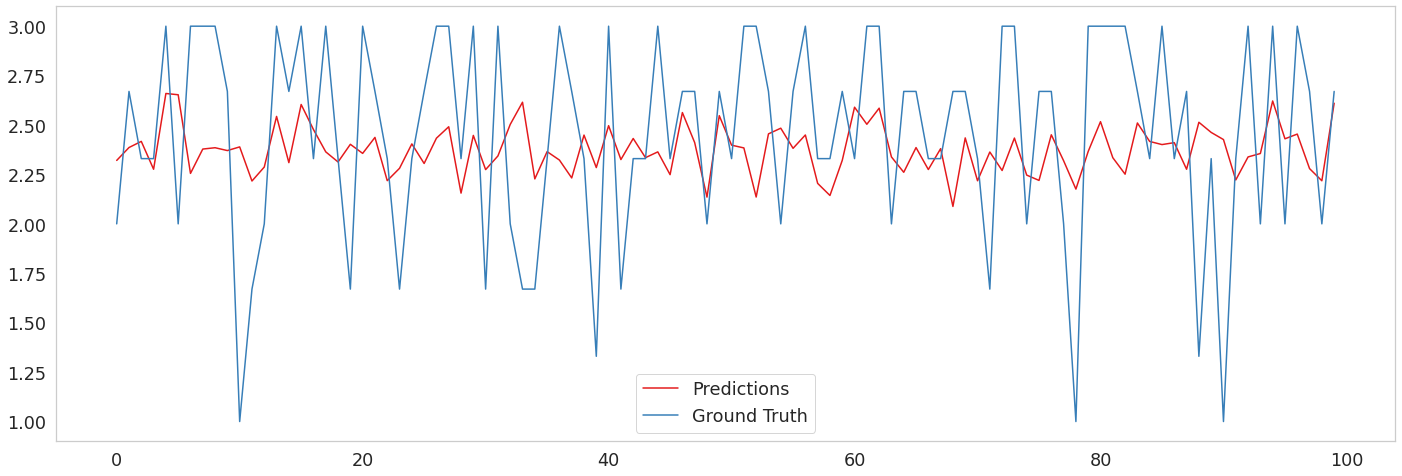

In [0]:
sns.set()
sns.set(style='whitegrid', palette=("Set1"), font_scale=1.6, rc={"figure.figsize": [24, 8]})
x=range(len(list(y_test)[100:200]))
ax = sns.lineplot(x=x, y=list(y_pred)[100:200])
sns.lineplot(x=x, y=list(y_test)[100:200], ax=ax)
plt.legend(labels=['Predictions', 'Ground Truth'])
ax.grid(False)

**WE CAN USE FEATURE SELECTION FOR THE BEST FEATURES (site: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e )**

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# # 1st method
# bestfeatures = SelectKBest(score_func= chi2,
#                            k=5)
# fit = bestfeatures.fit(X,y)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# featureScores = pd.concat([dfcolumns, dfscores], axis=1)
# featureScores.columns = ['Featue','Score']  # naming the dataframe columns
# print(featureScores.nlargest(5,'Score'))  # print 5 best features

# # 2nd method
# print(model.feature_importances_) # use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(3,.plot(kind='barh')
# plt.show()
#or use another way to visualize them
importances = list(rf.feature_importances_)
feature_list = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show

NotFittedError: ignored

**CREATE A DATAFRAME FOR TEST RESULTS AND SAVE TO A CSV**

In [0]:
predictions = pd.DataFrame({"id": id_test,
                            "relevance": y_pred})
predictions.to_csv('predictions_rf.csv', index=False)